# Lecture 17: The Fast Fourier Transform
The Cooley-Tukey Fast Fourier Transform is defined by computing $\hat f_\nu$ recursively
on the even and odd indexed coefficients of $f_n$, where the number of samples
is a power of 2:

\begin{align}
\hat f_\nu &= E_\nu + e^{2\pi i \frac{\nu}{N}} O_\nu, &\nu=0,\dots,N/2-1 \\
\hat f_{\nu + N/2} &= E_\nu - e^{2\pi i \frac{\nu}{N}} O_\nu, &\nu=0,\dots,N/2-1,
\end{align}

where $E_\nu$ is the DFT computed for the even indices,
$$
E_\nu = \sum_{m=0}^{N/2-1} f_{2m} \, e^{-2\pi i \frac{\nu m}{N/2}},
$$
and $O_\nu$ is the DFT for the odd indices,
$$
O_\nu = \sum_{m=0}^{N/2-1} f_{2m+1} \, e^{-2\pi i \frac{\nu m}{N/2}}.
$$

The inverse DFT can be computed using the FFT as well by noting that

$$
\hat f_{N - \nu} = \sum_{n=0}^{N-1} f_n \, e^{-2\pi i \frac{(N-\nu)\,n}{N}} = 
    \sum_{n=0}^{N-1} f_n \, e^{2\pi i \frac{\nu n}{N}} \underbrace{e^{-2\pi i \frac{N n}{N}}}_{=e^{-2\pi in}=1}.
$$
This is the formula for the inverse DFT.
Thus, to compute the inverse DFT it is sufficient to compute the DFT and then reverse the order of the
resulting vector, except for the 0-th entry.

In [1]:
using PyPlot
PyPlot.svg(true);

In [2]:
function fft_ct(f)
    """ Implement the Cooley-Tukey algorithm
    to compute the DFT of the vector f.
    The length of f must be a power of 2.
    """
    N = length(f)
    
    # base case
    if N == 1
        return f
    end
    
    # Divide-and-conquer recursion
    
    # even indices
    E = fft_ct(f[1:2:end])
    # odd indices
    O = fft_ct(f[2:2:end])
    
    # combine
    fhat = zeros(ComplexF64, N)
    
    for ν=1:Int64(N/2)
        fhat[ν]              = E[ν] + exp(-2im*π*(ν-1)/N)*O[ν]
        fhat[ν + Int64(N/2)] = E[ν] - exp(-2im*π*(ν-1)/N)*O[ν]
    end
    
    return fhat
end

function ifft_ct(fhat)
    """ Inverse DFT is just DFT with reversed indices
    """
    N = length(fhat)
    
    f = fft_ct(fhat)
    f[2:end] = f[end:-1:2]
    
    return f
end

ifft_ct (generic function with 1 method)

In [3]:
f = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

fhat = fft_ct(f)/length(f)

8-element Array{Complex{Float64},1}:
                  4.5 - 0.0im                
                 -0.5 + 1.2071067811865475im 
                 -0.5 + 0.5im                
                 -0.5 + 0.20710678118654746im
                 -0.5 + 0.0im                
 -0.49999999999999994 - 0.20710678118654746im
 -0.49999999999999994 - 0.5im                
 -0.49999999999999983 - 1.2071067811865475im 

In [4]:
ifft_ct(fhat)

8-element Array{Complex{Float64},1}:
 1.0000000000000002 + 0.0im                   
 2.0000000000000004 - 4.498103985761725e-16im 
                3.0 - 3.4450928483976665e-16im
                4.0 - 3.273457186614371e-16im 
                5.0 + 0.0im                   
                6.0 + 2.1632341619892146e-16im
                7.0 + 3.4450928483976665e-16im
                8.0 + 5.608327010386881e-16im 

## Comparing performance of FFT and naive DFT

In [5]:
function DFT(f)
    """ Compute the naive Discrete Fourier Transform of the vector f
    """
    N = length(f)
    
    fhat = zeros(ComplexF64, N)
    
    for ν=0:N-1
        for n=0:N-1
            fhat[ν+1] += f[n+1]*exp(-2im*π*n*ν/N)/N
        end
    end
    
    return fhat
end

DFT (generic function with 1 method)

In [6]:
# Compare runtime for a 1 minute audio file
using WAV

audio, Fs, nbits, _ = wavread("pzm12.wav")

([-0.000305185 0.00305185; -0.00021363 0.00347911; … ; 0.000854518 0.00253304; 0.000854518 0.00277718], 16000.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x02, 0x00, 0x80, 0x3e, 0x00, 0x00, 0x00, 0xfa, 0x00, 0x00, 0x04, 0x00, 0x10, 0x00])])

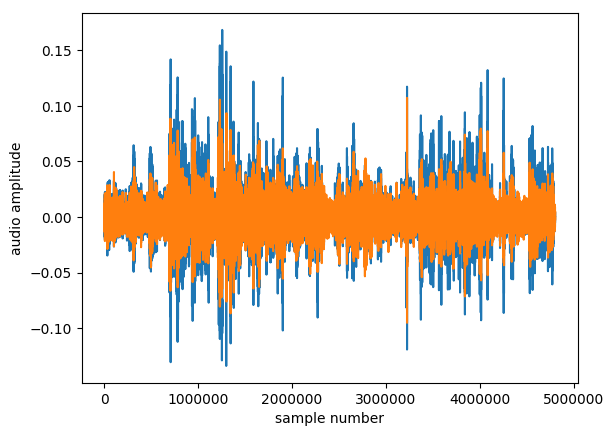

PyObject Text(0.5, 24.0, 'sample number')

In [7]:
figure()

plot(audio)
ylabel("audio amplitude")
xlabel("sample number")

In [12]:
2^22/2^14

256.0

In [26]:
# compute FFT of the left channel audio signal, cut to 2^22 samples, the closest power of 2
@time audio_dft = fft_ct(audio[1:2^22,1]);

  3.797105 seconds (12.59 M allocations: 3.078 GiB, 16.12% gc time)


In [13]:
# compute naive DFT of the same audio signal, cut to 2^14 samples
# the original 2^22 samples would take hours!

@time DFT(audio[1:2^15,1]);

 28.152408 seconds (1.93 k allocations: 883.949 KiB)


In [16]:
# Compare to the Fastest Fourier Transform in the West (FFTW)
using FFTW

@time fft(audio[1:2^15,1]);

  0.001440 seconds (62 allocations: 1.253 MiB)


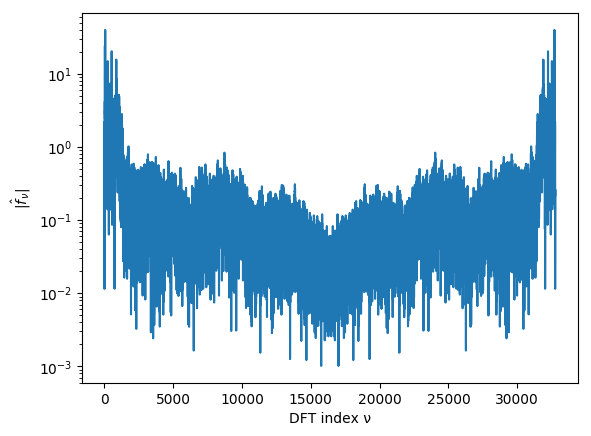

PyObject Text(33.236111111111114, 0.5, '$|\\hat f_ν|$')

In [20]:
figure()

semilogy(abs.(audio_dft))

xlabel("DFT index ν")
ylabel(L"|\hat f_ν|")

## Lossy audio compression
The Fourier spectrum is strongly concentrated. This suggests a scheme for compressing audio data:
Take a Fourier Transform, throw out all the coefficients that are close to zero and store
only the nonzero ones.

Many audio compression formats such as MP3 or Ogg work this way. To decide which frequencies to discard, they resort to a psychoacoustic model: Discard frequencies that humans either can't hear or can't distinguish from one another.

In [23]:
# Play 10 seconds

wavplay(audio[1:Int64(Fs*10),1], Fs)

In [27]:
# throw out 80% of data from the DFT

# sort indices by absolute value of the DFT
# since the signal is real, we work on just one half of the spectrum and then
# set to zero symmetrically
N = length(audio_dft)
dft_indices = 1 .+ sortperm(abs.(audio_dft[2:Int64(N/2)-1]))

# set to zero
audio_dft_lossy = copy(audio_dft)

indices_to_zero = dft_indices[1:Int64(trunc(0.85*length(dft_indices)))]
audio_dft_lossy[indices_to_zero] .= 0.0
audio_dft_lossy[(N + 2) .- indices_to_zero] .= 0.0;

# inverse FFT
audio_lossy = ifft(audio_dft_lossy)

4194304-element Array{Complex{Float64},1}:
    0.002802737387012943 + 3.878140349003814e-18im 
   0.0017189814546035276 + 2.5387447860845034e-18im
   0.0004105106006996816 + 1.425801611630608e-19im 
 -0.00035867722711520984 - 1.4722754022150964e-19im
  -0.0006803624646094433 - 1.0181458226065193e-18im
  -0.0009721288614194285 + 1.1164940574161871e-18im
  -0.0010623918720727584 - 2.384221417214353e-18im 
  -0.0003639801411108373 - 1.8786441263846165e-18im
   0.0010230487643897914 - 4.229427055454106e-19im 
   0.0020390187227511615 - 1.0779085265643698e-18im
    0.001908784975435777 - 3.167407810559021e-19im 
   0.0011518808915398594 + 2.100458339304582e-18im 
   0.0008773251123649212 + 8.555910501742153e-19im 
                         ⋮                         
   0.0013702538286876754 + 3.9788590034705686e-18im
   0.0004935907697721648 - 1.907315510617241e-18im 
   0.0003796891505831821 - 2.6022059878878213e-18im
   0.0011307500801630808 - 2.75046737427985e-19im  
    0.002255769177600

In [28]:
# We can still hear the people talk, at an 85% reduced file size!
audio_lossy = real(audio_lossy)

wavplay(audio_lossy[1:Int64(Fs*10),1], Fs)

## Lossy image compression
The same ideas as for audio compression can also be applied to images.
They are implemented, for example in the well-known JPEG format.
While JPEG is slighty more sophisticated, the same ideas that worked for the audio case
will also work for a generic image.

Because images are 2-dimensional, we need the 2D generalization of the DFT, which
transforms a $N\times M$ matrix $A_{nm}$,

$$
\hat A_{\nu\mu} = \frac{1}{N\, M} \sum_{n=0}^{N-1} \sum_{m=0}^{M-1} A_{nm}\, e^{-2\pi i \frac{n\, \nu}{N}}
e^{-2\pi i \frac{m\, \mu}{M}}.
$$

The inverse transform is
$$
A_{nm} = \sum_{\nu=0}^{N-1} \sum_{\mu=0}^{M-1} \hat A_{\nu\mu}\, e^{2\pi i \frac{n\, \nu}{N}}
e^{2\pi i \frac{m\, \mu}{M}},
$$

in analogy to the $n$-d Fourier transform.

In contrast to audio data, images are generally stored using three channels, one for each
color. The idea is then to Fourier transform each of those channels, throw away unimportant frequencies to reduce file size, and finally to reconstruct the image.

In [29]:
cat_picture = imread("Felis_silvestris_silvestris.png")

925×800×3 Array{Float32,3}:
[:, :, 1] =
 0.517647  0.529412  0.533333  0.529412  …  0.686275  0.682353  0.690196
 0.521569  0.529412  0.541176  0.537255     0.694118  0.690196  0.686275
 0.517647  0.529412  0.537255  0.54902      0.698039  0.694118  0.694118
 0.509804  0.517647  0.529412  0.545098     0.705882  0.709804  0.705882
 0.509804  0.517647  0.529412  0.54902      0.717647  0.721569  0.709804
 0.521569  0.517647  0.52549   0.533333  …  0.72549   0.72549   0.717647
 0.521569  0.529412  0.52549   0.52549      0.729412  0.733333  0.72549 
 0.529412  0.541176  0.533333  0.533333     0.733333  0.733333  0.733333
 0.52549   0.529412  0.545098  0.545098     0.733333  0.737255  0.729412
 0.533333  0.541176  0.545098  0.541176     0.737255  0.737255  0.741176
 0.537255  0.54902   0.545098  0.556863  …  0.741176  0.745098  0.737255
 0.545098  0.552941  0.560784  0.560784     0.74902   0.74902   0.745098
 0.541176  0.556863  0.556863  0.556863     0.756863  0.752941  0.74902 
 ⋮         

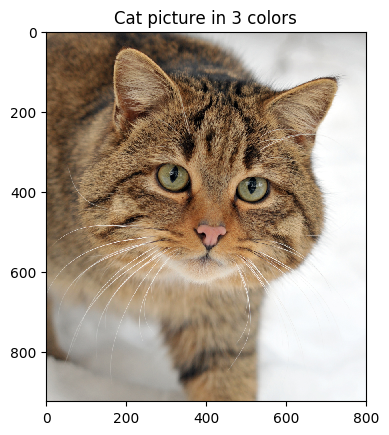

PyObject <matplotlib.image.AxesImage object at 0x7fe3a14cfdd8>

In [30]:
figure()

title("Cat picture in 3 colors")
imshow(cat_picture)

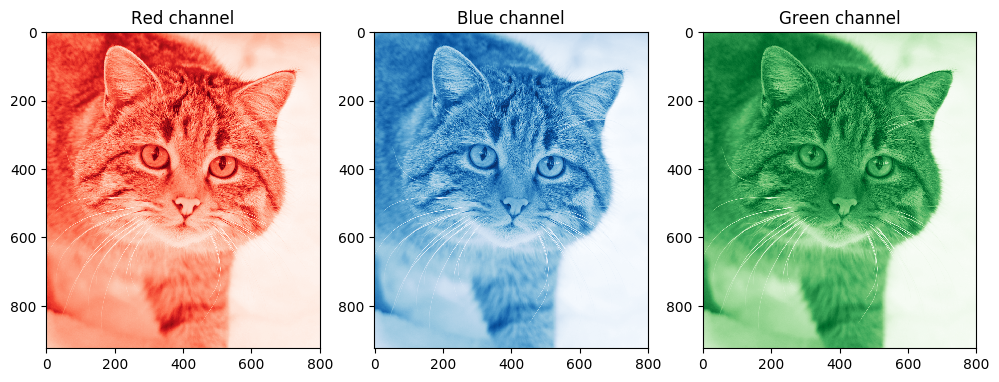

PyObject <matplotlib.image.AxesImage object at 0x7fe3a1544278>

In [31]:
fig, axs = subplots(1, 3, figsize=(12, 6))

axs[1].set_title("Red channel")
axs[1].imshow(cat_picture[:,:,1], cmap="Reds_r")

axs[2].set_title("Blue channel")
axs[2].imshow(cat_picture[:,:,2], cmap="Blues_r")

axs[3].set_title("Green channel")
axs[3].imshow(cat_picture[:,:,3], cmap="Greens_r")

In [32]:
# Real Fourier transform (rfft) the red channel
# the rfft function only stores half of the entries because of the symmetry f_{-ν} = f_ν^* for real f_n.

red_dft = rfft(cat_picture[:,:,1])

463×800 Array{Complex{Float32},2}:
 4.77404e5+0.0im        35240.2+41801.8im  …   35240.2-41801.8im
   2387.26+43983.8im    2928.41+6649.75im       3619.0-19034.6im
  -4226.55-722.179im   -2204.42+9530.09im     -4570.46+4069.88im
   12858.1+2289.42im    2087.26+5215.49im     -8956.56-3816.29im
  -2248.47+1943.26im    3506.04+1824.42im     -2438.71+719.893im
   4.32767+4003.28im    1818.09+944.725im  …  -6988.01+3600.1im 
    1045.1+4412.45im    234.328-160.074im     -4137.08+3941.97im
  -1539.02+7198.9im    -1507.27-784.327im      1422.81+753.686im
   532.443+3837.0im    -15.4109-215.999im     -2098.02-188.877im
   404.449+1400.21im    -401.56+957.969im      -2852.3+326.002im
  -304.936+2162.47im    1977.44+1087.71im  …   169.568-707.964im
   629.094+273.436im    1734.39+915.187im     -4149.45+2658.1im 
   956.554+1023.07im    661.719-1360.91im     -711.476+3166.46im
          ⋮                                ⋱                    
  -40.8319-1.86696im   -29.2634+8.03783im     -32.7378-

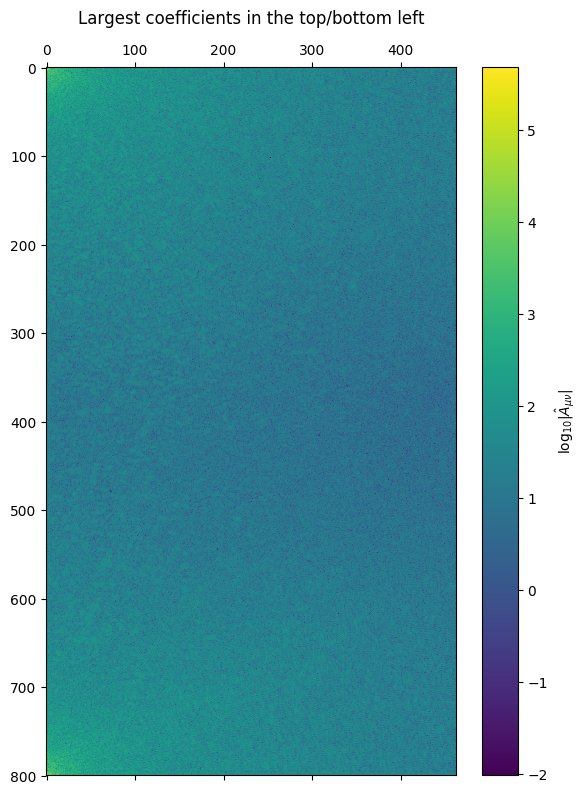

In [33]:
fig, ax = subplots(1, 1, figsize=(6, 8))

ax.set_title("Largest coefficients in the top/bottom left")
sc = ax.matshow(log10.(abs.(red_dft))')
fig.colorbar(sc, ax=ax, label=L"\log_{10}|\hat A_{\mu\nu}|")

fig.tight_layout()

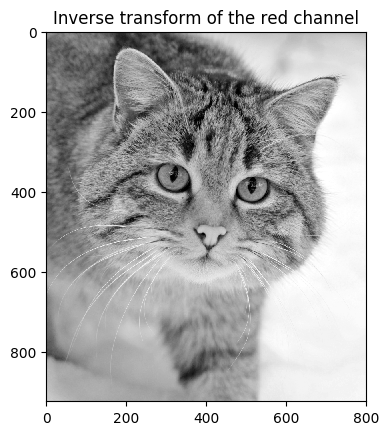

PyObject <matplotlib.image.AxesImage object at 0x7fe3a14bfbe0>

In [34]:
figure()

title("Inverse transform of the red channel")
imshow(irfft(red_dft, size(cat_picture)[1]), cmap="binary_r")

In [50]:
# Throw away small coefficients
compr_dft = copy(red_dft)

max = maximum(abs.(compr_dft))
compr_dft[abs.(compr_dft) .< 1e-2*max] .= 0.0;

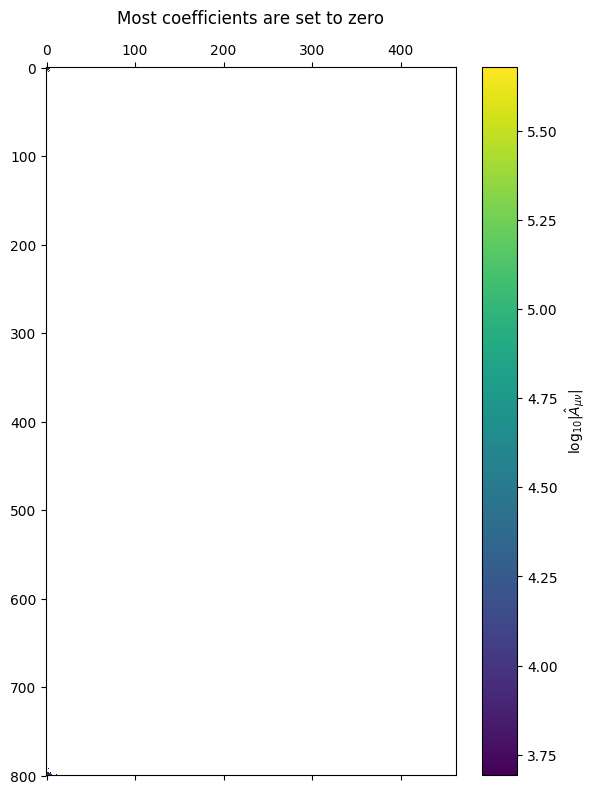

In [51]:
fig, ax = subplots(1, 1, figsize=(6, 8))

ax.set_title("Most coefficients are set to zero")
sc = ax.matshow(log10.(abs.(compr_dft))')
fig.colorbar(sc, ax=ax, label=L"\log_{10}|\hat A_{\mu\nu}|")

fig.tight_layout()

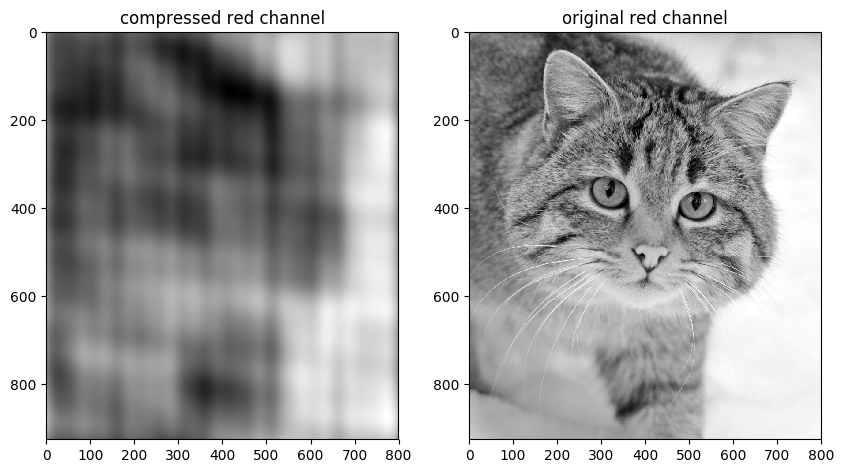

PyObject <matplotlib.image.AxesImage object at 0x7fe39aecd5f8>

In [52]:
fig, axs = subplots(1, 2, figsize=(10, 6))

axs[1].set_title("compressed red channel")
axs[1].imshow(irfft(compr_dft, size(cat_picture)[1]), cmap="binary_r")

axs[2].set_title("original red channel")
axs[2].imshow(irfft(red_dft, size(cat_picture)[1]), cmap="binary_r")

### The real JPEG algorithm

The real JPEG algorithm improves on this simple implementation in many respects.
Most importantly, 

* The image is divided into $8\times 8$ pixel blocks, and each block is transformed individually to compress different parts of the image differently.

* The color space used is not RGB, but a space specifically adapted to human color perception

* Instead of the DFT, JPEG uses a discrete cosine transform (DCT), which is always real and shows fewer "ringing artifacts" (essentially, the Gibbs phenomenon when the image is periodically continued)

* The DCT coefficients are again compressed using a lossless compression algorithm

## Spectral methods for PDEs

Let's say we want to solve the Poisson equation in 2D,
$$
\left( \frac{\partial^2}{\partial x^2} +  \frac{\partial^2}{\partial y^2} \right) \phi(x,y) = \rho(x,y).
$$

with periodic boundary conditions on an $L\times L$ domain.
We can expand the solution and the RHS in terms of Fourier series,

$$
\phi(x,y) = \sum_{\mu,\nu\in \mathbb{Z}} \hat\phi_{\mu\nu} e^{-2\pi i \frac{\mu x + \nu y}{L}}
$$
$$
\rho(x,y) = \sum_{\mu,\nu\in \mathbb{Z}} \hat\rho_{\mu\nu} e^{-2\pi i \frac{\mu x + \nu y}{L}}.
$$

Plugging these into the Poisson equation and comparing coefficients, we obtain the algebraic problem

$$
-\left(\frac{2\pi}{L}\right)^2 (\mu^2 + \nu^2) \phi_{\mu\nu} = \rho_{\mu\nu}.
$$

Thus, an algorithm for solving this PDE is to

* FFT the right side on an $N\times N$ grid
* Solve the algebraic equation in Fourier space
* Transform back to obtain the solution $\phi(x,y)$

In [ ]:
# Right hand side

ρ = hcat([[ 100.0/(5000(x - 0.5)^2 + 1000(y - 0.5)^2 + 100.0) for y in LinRange(0, 1, 100) ] for x in LinRange(0, 1, 100)]...)

In [ ]:
figure()
matshow(ρ)
xlabel(L"x")
ylabel(L"y")
title(L"ρ(x)")

colorbar()

In [ ]:
ρ_hat = fft(ρ)

ϕ_hat = zeros(ComplexF64, 100, 100)
# Solve the algebraic problem
for μ=-50:49
    for ν=-50:49
        # the 0-0 component is a free parameter corresponding to a constant added to the solution
        if (μ != 0) && (ν != 0)
            ϕ_hat[μ+51,ν+51] = -ρ_hat[μ+51,ν+51]/((2π)^2*(μ^2 + ν^2))
        end
    end
end

In [ ]:
ϕ = real(ifft(ϕ_hat))

figure()
matshow(ϕ)
xlabel(L"x")
ylabel(L"y")
title("solution ϕ(x)")

colorbar()

## Zero padding for FFT convolutions
The FFT can be used to compute mod-$N$ convolutions. Often, we want to avoid the mod-$N$ arithmetic. This is done by zero-padding.

In [ ]:
# Want to calculate 

321 * 31

In [ ]:
# by FFT convolution

# 1*10^0 + 2*10^1 + 3*10^2
x = [1; 2; 3]

# 1*10^0 + 3*10^1 + 3*10^2
y = [1; 3; 0]

In [ ]:
xhat = fft(x)
yhat = fft(y)

zhat = xhat.*yhat

z = ifft(zhat)

In [ ]:
# reconstruct product (wrong because of mod-N arithmetic)
10 + 5*10 + 10*100

In [ ]:
# Now with zero padding
x = [1; 2; 3; 0; 0; 0]
y = [1; 3; 0; 0; 0; 0]

xhat = fft(x)
yhat = fft(y)

zhat = xhat.*yhat

z = ifft(zhat)

In [ ]:
# reconstruct product
1 + 5*10 + 9*100 + 9*1000

In [ ]:
321 * 31